### Plotagens do modelo LSTM com o arquivo 694.csv

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.random import set_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, max_error, mean_absolute_error

In [2]:
# Carregar dados do CPU
machine = 'm_694.csv'
workload = pd.read_csv(machine, 
             names = ['machine_id', 'time_stamp', 'cpu', 'mem', 'mem_gps', 
                      'mkpi', 'net_in', 'net_out', 'disk_io_percent'])
workload.time_stamp = pd.to_datetime(workload.time_stamp, unit='s')
workload.set_index('time_stamp', inplace=True)
workload = workload.resample('5min').interpolate()
workload = workload[-12*24*3:] # 5min * 12 * 24 * 3 = 3 days
workload

,machine_id,cpu,mem,mem_gps,mkpi,net_in,net_out,disk_io_percent
time_stamp,,,,,,,,
1970-01-06 00:00:00,m_694,25.0,96.0,NaN,NaN,46.14,39.77,5.0
1970-01-06 00:05:00,m_694,31.0,97.0,NaN,NaN,46.15,39.78,5.0
1970-01-06 00:10:00,m_694,34.0,94.0,NaN,NaN,46.15,39.78,8.0
1970-01-06 00:15:00,m_694,31.0,92.0,NaN,NaN,46.16,39.79,4.0
1970-01-06 00:20:00,m_694,32.0,94.0,NaN,NaN,46.16,39.79,4.0
...,...,...,...,...,...,...,...,...
1970-01-08 23:35:00,m_694,86.0,91.0,0.35,0.0,51.46,44.74,4.0
1970-01-08 23:40:00,m_694,86.0,92.0,0.27,0.0,51.46,44.75,6.0
1970-01-08 23:45:00,m_694,85.0,92.0,0.45,0.0,51.46,44.75,6.0


In [3]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back
        X.append(data_arr[i:d,])
        Y.append(data_arr[d,])
    return np.array(X), np.array(Y)

In [4]:
#create numpy.ndarray
df1 = workload['cpu']
df_arr= df1.values
df_arr = np.reshape(df_arr, (-1, 1)) #LTSM requires more input features compared to RNN or DNN
scaler = MinMaxScaler(feature_range=(0, 1))#LTSM is senstive to the scale of features
df_arr = scaler.fit_transform(df_arr)

In [5]:
train_size = int(len(df1) * 2/3)
test_size = len(df_arr) - train_size
train, test = df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
look_back = 12
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [6]:
def model_lstm(look_back):
    model=Sequential()
    model.add(LSTM(15, input_shape=(1, look_back), activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse',  optimizer='adam',metrics = ['mse'])
    return model

In [7]:
# disable random weigths
np.random.seed(1234)
set_seed(1234)

model=model_lstm(look_back)
history = model.fit(trainX, trainY, epochs=150, batch_size=30, validation_data=(testX, testY), 
                    verbose=0, shuffle=False)

In [8]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

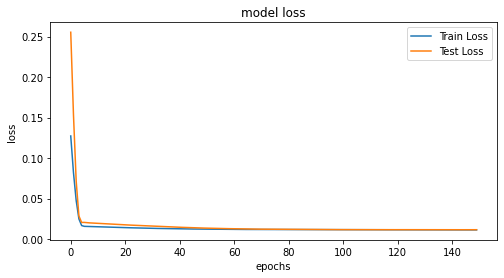

In [9]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)[:,0]
trainY = scaler.inverse_transform(trainY)[:,0]
test_predict = scaler.inverse_transform(test_predict)[:,0]
testY = scaler.inverse_transform(testY)[:,0]
model_loss(history)

<AxesSubplot:xlabel='time_stamp'>

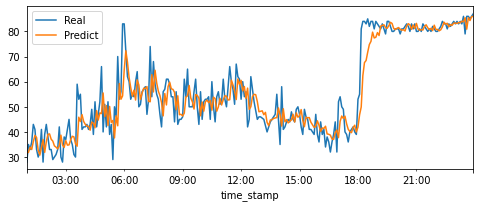

In [10]:
test_results = pd.DataFrame({'Real':testY, 'Predict': test_predict}, index=workload[-len(testY):].index)
test_results.plot(figsize=(8,3))